# Housing Market Analysis in Hyderabad 
This project analyzes the Hyderabad Housing dataset to better understand property trends and key housing features. Our goal is to build a clear, consistent workflow that demonstrates Python-based data engineering, preprocessing, and modeling.
#### Scott Schmidt - Illinois State University - IT 478

--------------------------------------------
# View Data - Step 1
Data Source: "HyderabadHousingPrices.csv", containing detailed information about housing prices and features in Hyderabad. Perform data cleaning on the HYDERABAD_HOUSING table, ensuring standardization of formats for fields such as Area, No_of_Bedrooms, New_Resale, Gym, and Price.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

df = pd.read_excel('/kaggle/input/houseprice/HyderabadHousingPrices.xlsx')
df.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


--------------------------------------------
# Data Cleaning - Part 2
Perform data cleaning such as following:
* Handling missing or null values
* Ensuring numeric fields are properly typed
* Standardizing categorical variables
* Removing duplicate entries
* Verifying consistency across all feature columns

In [2]:
df_shape = df.shape
print("Original data shape: ", df_shape)

dups_count = df.duplicated().sum()
print("There are this many dups: ", dups_count)

Original data shape:  (2518, 40)
There are this many dups:  520


In [3]:
df = df.drop_duplicates()
df_shape = df.shape
df_shape

(1998, 40)

----------------------------
# House Features - Part 3
Create a table named HOUSE_FEATURES that includes the following columns from
HYDERABAD_HOUSING: Area, No_of_Bedrooms, Gym, Lift, SwimmingPool, and Resale.

For analaysis, I used linear regression since its most common and easier to interpret. House features can be analyzed on an individual basis to see how much each feature influences the final house price. 

In [4]:
#Column list
cols = df.columns
df = df[cols]  

# 1. Split target & features
y = df["Price"]
X = df.drop(columns=["Price"])

# Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# 3. Linear Regression Model
lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

In [6]:
# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Location'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['Area', 'No. of Bedrooms', 'Resale', 'MaintenanceStaff', 'Gymnasium',
       'SwimmingPool', 'LandscapedGardens', 'JoggingTrack',
       'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall', 'Intercom',
       '...se', 'School', '24X7Security',
       'PowerBackup', 'CarParking', 'StaffQuarter', 'Cafeteria',
       'MultipurposeRoom', 'Hospital', 'WashingMachine', 'Gasconnection', 'AC',
       'Wifi', 'Children'splayarea', 'LiftAvailable', 'BED', 'VaastuCompliant',
       'Microwave', 'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe',
       'Refrigerator'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

R² tells you how well your model’s predictions match the real data.
* R² = 1.0 → perfect predictions
* R² = 0.0 → the model is useless (no better than guessing the average)
Therefore, .82 means one can explain about 82% of the data.

In [7]:
#Results
r2 = lr.score(X_test, y_test)
r2 = round(r2, 4)
print("R² score:", r2)

R² score: 0.8181


In [8]:
'''
RMSE (Root Mean Squared Error):
How far far are the house predictions off by?
Most simple standard error metric often used with linear regression.
'''
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

# Hold-out predictions
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse_rupees = mean_squared_error(y_test, y_pred, squared=False)

# Conversion rate (approx)
usd_rate = 0.012
rmse_usd = rmse_rupees * usd_rate # Convert to USD

print(f"RMSE (Rupees): {rmse_rupees:,.0f}")
print(f"Approx RMSE (USD): ${rmse_usd:,.0f}")


# 5-fold cross validation using MSE
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores.mean()) ** 0.5

cv_rmse_usd = cv_rmse * usd_rate
print(f"5-fold CV RMSE: {cv_rmse:,.0f}")
print(f"Approx RMSE (USD): ${cv_rmse_usd:,.0f}")

RMSE (Rupees): 3,726,180
Approx RMSE (USD): $44,714
5-fold CV RMSE: 5,096,884
Approx RMSE (USD): $61,163


In [9]:
import numpy as np

#preprocessor = model.named_steps["preprocessor"]
regressor = lr.named_steps["regressor"]

feature_names = preprocessor.get_feature_names_out()
coeffs = np.abs(regressor.coef_)

top_idx = np.argsort(coeffs)[-10:]          # change 10 to however many you want
top_features = feature_names[top_idx]
top_values = coeffs[top_idx]

for name, value in sorted(zip(top_features, top_values), key=lambda x: -x[1]):
    print(f"{name}: {value:.3f}")

cat__Location_Boiguda: 18794046.678
cat__Location_Abids: 18643480.814
cat__Location_Film Nagar: 13853484.738
cat__Location_Sangeet Nagar: 12775272.066
cat__Location_Saket: 10969138.949
cat__Location_Banjara Hills: 9513185.805
cat__Location_Jubilee Hills: 9418224.153
cat__Location_Banjara Hills Road Number 12: 9302066.332
cat__Location_Whitefields: 8210255.362
cat__Location_Pocharam: 7732208.056


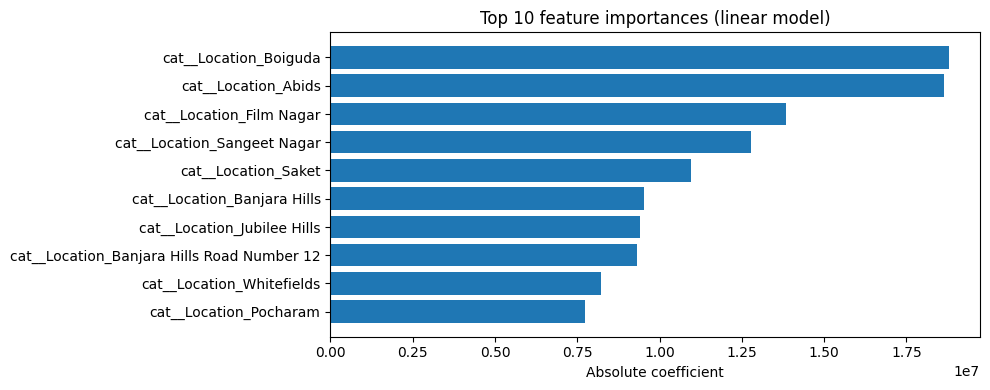

In [10]:
# print(lr.named_steps.keys()) # See the actual step names 
feature_names = lr.named_steps['preprocessor'].get_feature_names_out()
coeffs = np.abs(lr.named_steps['regressor'].coef_)

top_n = 10  # change to 6 if you want only six
top_idx = np.argsort(coeffs)[-top_n:]
top_features = feature_names[top_idx]
top_values = coeffs[top_idx]

plt.figure(figsize=(10, 4))
plt.barh(top_features, top_values)
plt.xlabel("Absolute coefficient")
plt.title(f"Top {top_n} feature importances (linear model)")
plt.tight_layout()
plt.show()

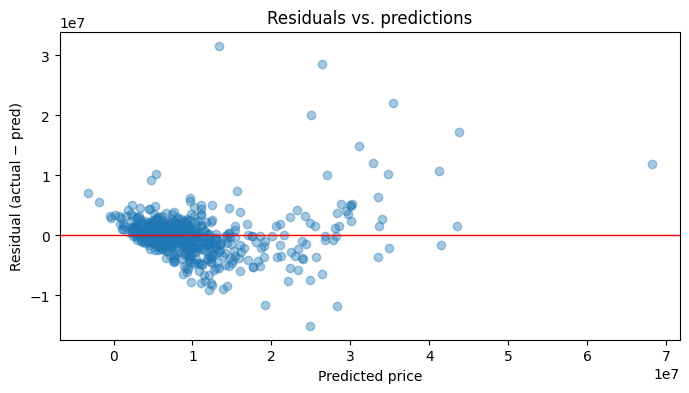

In [11]:
# Residual plot to check spread/heteroscedasticity
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linewidth=1)
plt.xlabel("Predicted price")
plt.ylabel("Residual (actual − pred)")
plt.title("Residuals vs. predictions")
plt.show()

--------------------------------------------
# Price Analysis - Part 4
* Define and populate the PRICE_ANALYSIS table with the following columns:
* AverageArea: The average area of houses sold.
* MedianPrice: The median price of houses.
* TotalHousesSold: The total number of houses sold.



In [12]:
average_price = df['Price'].mean().round(0)
median_price = df['Price'].median()
total_houses_sold = len(df)
print(average_price, " average price")
print(median_price, " median price")
print(total_houses_sold, " houses sold")

10141268.0  average price
7873500.0  median price
1998  houses sold


In [13]:
price_analysis = pd.DataFrame([{
    "average_area": df["Area"].mean().round(2),  # if you want area too
    "average_price": average_price,
    "median_price": median_price,
    "total_houses_sold": total_houses_sold
}])
price_analysis

,average_area,average_price,median_price,total_houses_sold
0,1673.0,10141268.0,7873500.0,1998


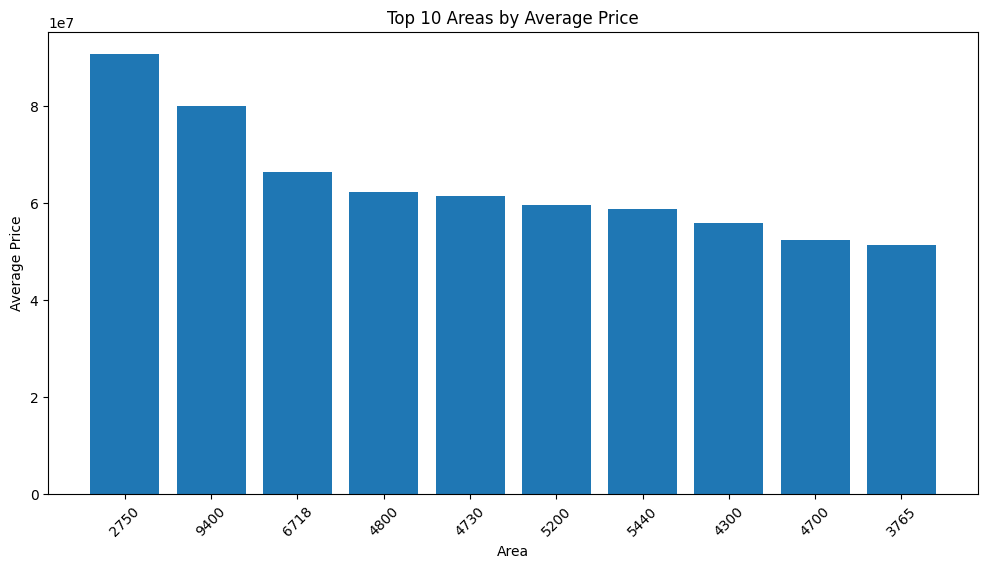

In [14]:
# Group by 'Area' and calculate mean price
area_stats = df.groupby('Area')['Price'].mean().sort_values(ascending=False)

# Top 10 areas by average price
top_areas = area_stats.head(10).reset_index()

#Graph
plt.figure(figsize=(12,6))
plt.bar(top_areas['Area'].astype(str), top_areas['Price'])
plt.xticks(rotation=45)
plt.xlabel('Area')
plt.ylabel('Average Price')
plt.title('Top 10 Areas by Average Price')
plt.show()

-----------------------------------------------
# Export DDL and Data - Part 5 
Export the DDL and data for both the HOUSE_FEATURES and PRICE_ANALYSIS tables.

In [15]:
df.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
df.to_csv('house_features.csv', index=False)
print("CSV exported as house_features.csv")

CSV exported as house_features.csv


--------------------------------
# Export File - Part 6
Export the data from the PRICE_ANALYSIS table into an Excel file.

In [17]:
price_analysis.head()

,average_area,average_price,median_price,total_houses_sold
0,1673.0,10141268.0,7873500.0,1998


In [18]:
# Export to CSV
price_analysis.to_csv('house_summary.csv', index=False)
print("CSV exported as house_summary.csv")

CSV exported as house_summary.csv


-------------------------------------------
# Generate Schema Report - Part 7
The purpose of this Python version is to extend the existing housing dataset by creating a dedicated PRICE_ANALYSIS table to store valuation metrics for each property, linked to the house features already present in the Kaggle dataset.

For a more in depth price analysis, other models such as random forest or xgBoost would be additionally performed.